In [43]:

import numpy as np
import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from math import *
from scipy import interpolate
from scipy.optimize import curve_fit 
from astropy.io import fits
from astropy.table import Table
from astropy.table import vstack
from astropy.coordinates import SkyCoord, ICRS, Galactic
# import astropy.units as u
import astropy.units as units
import astropy.coordinates as coord
#from matplotlib.colors import LogNorm
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# #import matplotlib.ticker as mtick
import os
#%matplotlib widget
import seaborn as sns
import os, sys
# from astropy.io import ascii
# from astropy.coordinates import galactocentric_frame_defaults
import sklearn
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from scipy import interpolate
import random
from scipy import integrate

import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
import sys,glob
from pathlib import Path
from ppxf.ppxf import ppxf, robust_sigma
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins
from tqdm import tqdm  
from astropy.io import fits

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

class SSPTemplateViewer:
    def __init__(self, npz_path):
        """初始化模板查看器"""
        try:
            self.data = np.load(npz_path, allow_pickle=True)
            print("Available keys in the file:")
            print(self.data.files)
            
            # 加载数据
            self._load_data()
            
        except Exception as e:
            print(f"Error loading npz file: {e}")
            raise
    
    def _get_array(self, key):
        """安全地获取数组"""
        try:
            return self.data[key] if key in self.data.files else None
        except Exception as e:
            print(f"Error loading {key}: {e}")
            return None
            
    def _load_data(self):
        """加载并验证数据"""
        # 获取数据
        templates = self._get_array('templates')
        self.templates = np.transpose(templates, (1, 2, 0))  # 转置为 (age, metal, wave)
        self.wave = self._get_array('lam')
        self.ages = self._get_array('ages')
        self.metals = self._get_array('metals')
        self.masses = self._get_array('masses')
        self.fwhm = self._get_array('fwhm')
        
        # 打印数组形状信息
        print("\nArray shapes after transformation:")
        print(f"templates shape: {self.templates.shape} (age, metal, wavelength)")
        print(f"wavelength shape: {self.wave.shape}")
        print(f"ages shape: {self.ages.shape}")
        print(f"metals shape: {self.metals.shape}")
        if self.metals.size < 10:
            print(f"metals values: {self.metals}")
        print(f"masses shape: {self.masses.shape}")
        print(f"fwhm shape: {self.fwhm.shape}")

    def plot_template(self, age_idx=None, metal_idx=None, normalize=True):
        """绘制特定模板"""
        try:
            # 设置默认索引
            if age_idx is None:
                age_idx = len(self.ages) // 2
            if metal_idx is None:
                metal_idx = len(self.metals) // 2
                
            # 获取光谱
            spectrum = self.templates[age_idx, metal_idx, :]
            
            if normalize:
                spectrum = spectrum / np.median(spectrum)
            
            # 绘图
            plt.figure(figsize=(12, 6))
            plt.plot(self.wave, spectrum, 'k-', lw=1)
            plt.xlabel('Wavelength (Å)')
            plt.ylabel('Normalized Flux' if normalize else 'Flux')
            
            # 添加标题
            title = f'SSP Template: Age={self.ages[age_idx]:.2f} Gyr, [M/H]={self.metals[metal_idx]:.2f}'
            plt.title(title)
            
            plt.grid(True, alpha=0.3)
            plt.show()
            
        except Exception as e:
            print(f"Error plotting template: {e}")
            raise

    def plot_age_sequence(self, metal_idx=None, n_ages=5):
        """绘制年龄序列"""
        try:
            if metal_idx is None:
                metal_idx = len(self.metals) // 2
                
            # 选择年龄索引
            age_indices = np.linspace(0, len(self.ages)-1, n_ages, dtype=int)
            
            plt.figure(figsize=(12, 6))
            for i, idx in enumerate(age_indices):
                spectrum = self.templates[idx, metal_idx, :].copy()
                spectrum = spectrum / np.median(spectrum)
                label = f'Age={self.ages[idx]:.2f} Gyr'
                plt.plot(self.wave, spectrum + i*0.5, label=label)
            
            plt.xlabel('Wavelength (Å)')
            plt.ylabel('Normalized Flux (offset for clarity)')
            plt.title(f'Age Sequence at [M/H]={self.metals[metal_idx]:.2f}')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
            
        except Exception as e:
            print(f"Error plotting age sequence: {e}")
            raise

    def plot_metal_sequence(self, age_idx=None, n_metals=None):
        """绘制金属丰度序列"""
        try:
            if age_idx is None:
                age_idx = len(self.ages) // 2
            
            if n_metals is None:
                n_metals = len(self.metals)
            
            plt.figure(figsize=(12, 6))
            for i, metal_idx in enumerate(range(n_metals)):
                spectrum = self.templates[age_idx, metal_idx, :].copy()
                spectrum = spectrum / np.median(spectrum)
                label = f'[M/H]={self.metals[metal_idx]:.2f}'
                plt.plot(self.wave, spectrum + i*0.5, label=label)
            
            plt.xlabel('Wavelength (Å)')
            plt.ylabel('Normalized Flux (offset for clarity)')
            plt.title(f'Metallicity Sequence at Age={self.ages[age_idx]:.2f} Gyr')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
            
        except Exception as e:
            print(f"Error plotting metal sequence: {e}")
            raise


In [ ]:
from typing import List, Union, Tuple
import numpy as np
from pathlib import Path

class WeightParser:
    """Class for parsing fitting weights to physical parameters."""
    
    def __init__(self, template_path: Union[str, Path]) -> None:
        """Initialize with SSP template.
        
        Args:
            template_path: Path to the SSP template .npz file
        """
        # 加载模板数据
        data = np.load(template_path, allow_pickle=True)
        self.ages = data['ages']      # 年龄数组 (25,)
        self.metals = data['metals']  # 金属丰度数组 (6,)
        
        # 验证模板维度
        if len(self.ages) != 25 or len(self.metals) != 6:
            raise ValueError(
                f"Invalid template dimensions: "
                f"ages={len(self.ages)}, metals={len(self.metals)}"
            )
            
        # 计算年龄的对数值
        self.log_ages = np.array([np.log10(age) if age > 0 else 0 
                                 for age in self.ages])
    
    def parse_weights(self, weights: Union[List[float], np.ndarray]) -> Tuple[float, float]:
        """Parse weights to get mean log(Age) and [M/H].
        
        Args:
            weights: Fitting weights, must have length 150 (25 ages × 6 metals)
            
        Returns:
            tuple: (mean_log_age, mean_metallicity)
            
        Notes:
            Weight matrix layout:
            - Each row (i) corresponds to an age value
            - Each column (j) corresponds to a metallicity value
            - weights[i*6 + j] gives the weight for age[i] and metal[j]
        """
        # 验证权重长度
        weights = np.array(weights)
        if len(weights) != 150:
            raise ValueError(f"Weights must have length 150, got {len(weights)}")
        
        # 计算总权重
        total_weight = np.sum(weights)
        if total_weight <= 0:
            raise ValueError("Total weight must be positive")
            
        # 计算年龄权重（每个年龄对应的6个权重之和）
        age_weights = np.array([np.sum(weights[i*6 : i*6+6]) 
                              for i in range(25)])
        
        # 计算金属丰度权重（每个金属丰度对应的25个权重之和）
        metal_weights = np.array([np.sum(weights[j::6]) 
                                for j in range(6)])
        
        # 计算平均对数年龄
        mean_log_age = np.sum(self.log_ages * age_weights) / total_weight
        
        # 计算平均金属丰度
        mean_metallicity = np.sum(self.metals * metal_weights) / total_weight
        
        return mean_log_age, mean_metallicity
    
    def get_physical_params(self, weights: Union[List[float], np.ndarray]) -> dict:
        """Get all physical parameters from weights.
        
        Args:
            weights: Fitting weights (150,)
            
        Returns:
            dict: Dictionary containing:
                - log_age: Mean log(Age)
                - age: Mean age in Gyr
                - metallicity: Mean [M/H]
        """
        log_age, metal = self.parse_weights(weights)
        
        return {
            'log_age': log_age,
            'age': 10**log_age,  # 转换回线性年龄
            'metallicity': metal
        }

In [45]:
sps_name = 'emiles'
spectrum_filename = 'VCC1588_stack.fits'
objfile = Path('E:/ProGram/Dr.Zheng/2024NAOC-IUS/Wkp/2024-NAOC-IUSpectrum/Ori_Data/'+spectrum_filename)
ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename

In [ ]:
# 初始化解析器
parser = WeightParser(filename)

In [46]:

viewer = SSPTemplateViewer(filename)

Available keys in the file:
['templates', 'masses', 'lam', 'ages', 'metals', 'fwhm']

Array shapes after transformation:
templates shape: (25, 6, 16675) (age, metal, wavelength)
wavelength shape: (16675,)
ages shape: (25,)
metals shape: (6,)
metals values: [-1.71 -1.31 -0.71 -0.4   0.    0.22]
masses shape: (25, 6)
fwhm shape: (16675,)


In [47]:
# 指定你的npz文件路径
viewer = SSPTemplateViewer(filename)

Available keys in the file:
['templates', 'masses', 'lam', 'ages', 'metals', 'fwhm']

Array shapes after transformation:
templates shape: (25, 6, 16675) (age, metal, wavelength)
wavelength shape: (16675,)
ages shape: (25,)
metals shape: (6,)
metals values: [-1.71 -1.31 -0.71 -0.4   0.    0.22]
masses shape: (25, 6)
fwhm shape: (16675,)


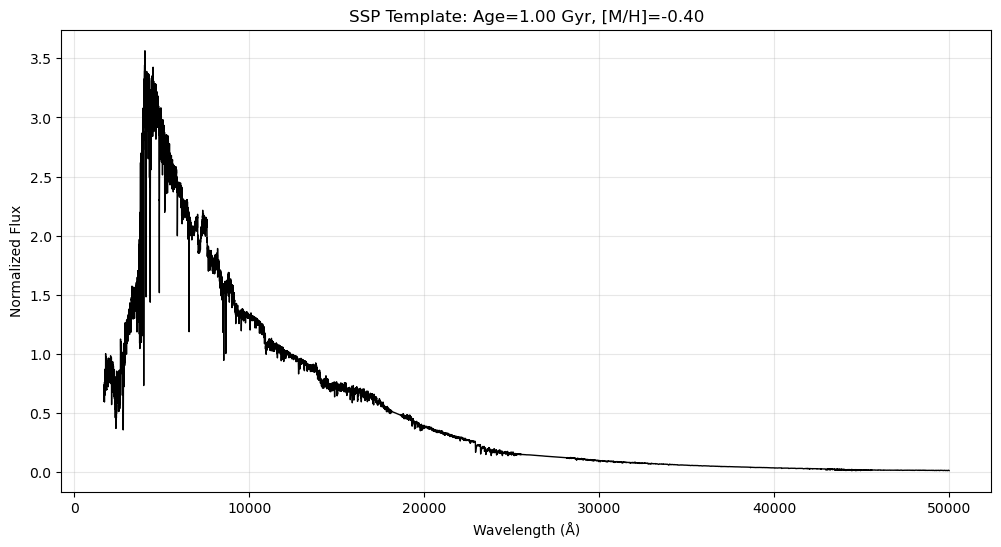

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_28192\1017802472.py:94: RuntimeWarning: divide by zero encountered in divide
  spectrum = spectrum / np.median(spectrum)
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_28192\1017802472.py:94: RuntimeWarning: invalid value encountered in divide
  spectrum = spectrum / np.median(spectrum)


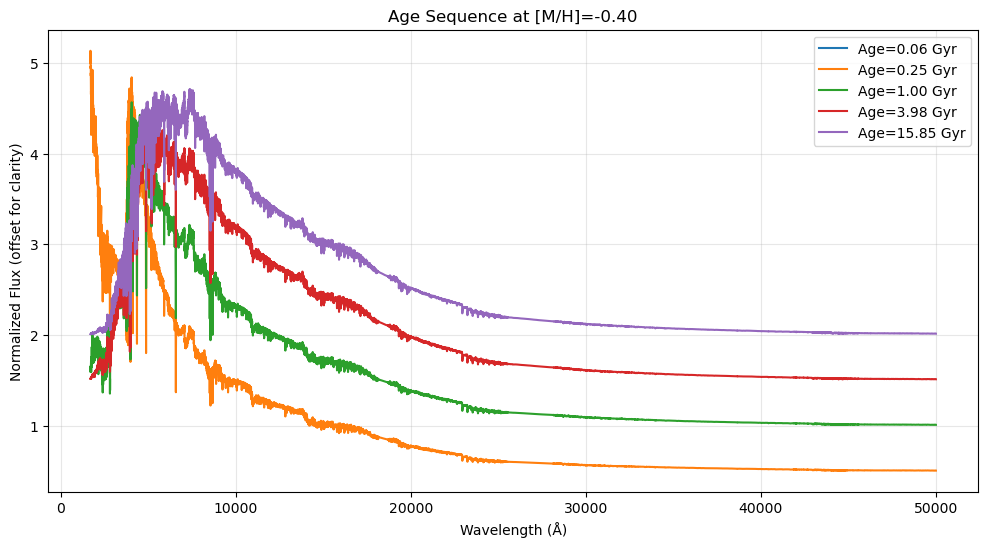

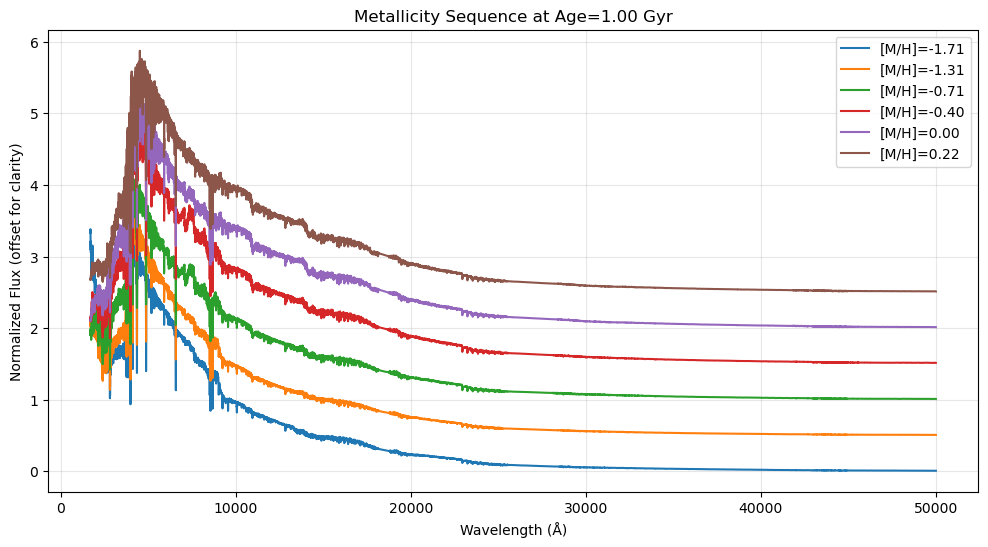

In [48]:
# 绘制单个模板（例如：中等年龄和金属度）
viewer.plot_template(age_idx=12, metal_idx=3)

# 绘制年龄序列（在特定金属度下）
viewer.plot_age_sequence(metal_idx=3, n_ages=5)

# 绘制金属丰度序列（在特定年龄下）
viewer.plot_metal_sequence(age_idx=12)